## Two-Dimensional Test of Unsaturated-Saturated Transport

This problem tests transport in the unsaturated zone.
This example originally appeared in Morway et al (2013).

### Initial setup

Import dependencies, define the example name and workspace, and read settings from environment variables.

In [1]:
import os
import pathlib as pl
from pprint import pformat

import flopy
import git
import matplotlib.pyplot as plt
import numpy as np
from flopy.plot.styles import styles
from modflow_devtools.misc import get_env, timed

# Example name and workspace paths. If this example is running
# in the git repository, use the folder structure described in
# the README. Otherwise just use the current working directory.
try:
    root = pl.Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None
workspace = root / "examples" if root else pl.Path.cwd()
figs_path = root / "figures" if root else pl.Path.cwd()

# Settings from environment variables
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)

### Define parameters

Define model units, parameters and other settings.

In [2]:
# Set scenario parameters (make sure there is at least one blank line before next item)
# This entire dictionary is passed to _build_models()_ using the kwargs argument
parameters = {
    "ex-gwt-uzt-2d-a": {
        "longitudinal_dispersivity": [0.5],
        "ratio_horizontal_to_longitudinal_dispersivity": [0.4],
        "ratio_vertical_to_longitudinal_dispersivity": [0.4],
    },
    "ex-gwt-uzt-2d-b": {
        "longitudinal_dispersivity": [
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.5,
            0.5,
            0.5,
            0.5,
            0.5,
            0.5,
            0.5,
            0.5,
        ],
        "ratio_horizontal_to_longitudinal_dispersivity": [
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.4,
            0.4,
            0.4,
            0.4,
            0.4,
            0.4,
            0.4,
            0.4,
        ],
        "ratio_vertical_to_longitudinal_dispersivity": [
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.4,
            0.4,
            0.4,
            0.4,
            0.4,
            0.4,
            0.4,
            0.4,
        ],
    },
}

# Scenario parameter units
#
# add parameter_units to add units to the scenario parameter table that is automatically
# built and used by the .tex input
parameter_units = {
    "longitudinal_dispersivity": "$m$",
    "ratio_horizontal_to_longitudinal_dispersivity": "unitless",
}

# Model units
length_units = "meters"
time_units = "days"

# Model parameters
nlay = 20  # Number of layers
nrow = 1  # Number of rows
ncol = 40  # Number of columns
delr = 0.25  # Column width ($m$)
delc = 0.25  # Row width ($m$)
delz = 0.25  # Layer thickness ($m$)
top = 5.0  # Top of the model ($m$)
k1 = 2.5  # Horizontal hydraulic conductivity ($m/day$)
vk = 0.5  # Vertical hydraulic conductivity ($m/day$)
Ss = 1e-5  # Aquifer storativity
sy = 0.35  # Specific yield
thtr = 0.1  # Residual water content
thts = 0.45  # Saturated water content
thti = 0.105  # Initial water content
eps = 4.0  # Brooks-Corey Epsilon
finf = 0.1  # Infiltration rate ($m/d$)
cfinf = 1.0  # Concentration of recharge in select cells($ppm$)
prsity = 0.45  # Porosity
al = 0.5  # Longitudinal dispersivity ($ft$)
trpt = 0.4  # Ratio of horizontal transverse dispersivity to longitudinal dispersivity
trpv = 0.4  # Ratio of vertical transverse dispersivity to longitudinal dispersivity
perlen = 60.0  # Simulation time ($days$)

# Additional model input
botm = [top - delz * k for k in range(1, nlay + 1)]
perlen = [perlen]
nper = len(perlen)
nstp = [120]
tsmult = [1.0]
laytyp = icelltype = 1
iconvert = 1
# Hydraulic Conductivity
hk = k1 * np.ones((nlay, nrow, ncol), dtype=float)
hk33 = vk * np.ones((nlay, nrow, ncol), dtype=float)
# Starting Heads:
s0 = np.empty((nrow * ncol), dtype=float)
strt = np.zeros((nlay, nrow, ncol), dtype=float)
for k in range(nlay):
    strt[k] = s0

# Active model domain
ibound = np.ones((nlay, nrow, ncol), dtype=int)
ibound_mf2k5 = ibound.copy()
ibound_mf2k5[0:15, 0, 0] = 0
ibound_mf2k5[0:15, 0, -1] = 0
ibound_mf2k5[0:11, 0, :] = 0  # upper lays w/ UZF don't need to be active
# ibound_mf2k5[ 0:11, 0, 0:3] = ibound_mf2k5[ 0:11, 0, 37:40] =  0
ibound_mf2k5[13:20, 0, 0] = -1
ibound_mf2k5[13:20, 0, -1] = -1
idomain = np.ones_like(ibound)
idomain[0:13, 0, 0] = idomain[0:13, 0, -1] = 0
strt = np.ones((nlay, nrow, ncol), dtype=float) * 1.625
sconc = 0.0

# UZF related boundary conditions
nuztop = 3
iuzfopt = 2
irunflg = 0
ietflg = 0
iuzfcb1 = 0
iuzfcb2 = 0
ntrail2 = 25
nsets2 = 80
iuzfbnd = np.ones((nrow, ncol), dtype=int)
iuzfbnd[0, 0] = iuzfbnd[0, ncol - 1] = 0
# Fixed properties
surfdep = 0.00001
vks = k1
thtr = 0.1
thts = 0.45
thti = 0.105
eps = 4.0
# UZF boundary stresses
finf_mfnwt = np.ones((nrow, ncol), dtype=float) * finf
finf_mfnwt[0, 0] = finf_mfnwt[0, ncol - 1] = 0  # Shut off the outer cells
pet = 0.0
extdp = 0.0
extwc = 0.0
ha = 0.0
hroot = 0.0
rootact = 0.0
packagedata = []
uztpackagedata = []
pd0 = []
for k in range(nlay):
    for j in range(1, ncol - 1):  # outside columns are not UZF cells
        iuzno = k * (ncol - 2) + (j - 1)  # in flopy, iuzno is 0-based
        if k == 0:
            lflag = 1
            surfdep = 0.1
        else:
            lflag = 0
            surfdep = 0.001
        ivertcon = iuzno + len(range(1, ncol - 1))
        # adjust if on bottom layer (no underlying conn.)
        # remember, setting ivertcon=0, which means there is no vertical
        # connection results in vertical connection being equal to 1 in the
        # model input...SET equal to -1 to compensate
        if k == nlay - 1:
            ivertcon = -1
        # <iuzno> <cellid(ncelldim)> <landflag> <ivertcon> <surfdep> <vks> <thtr> <thts> <thti> <eps> [<boundname>]
        uz = [
            iuzno,
            (k, 0, j),
            lflag,
            ivertcon,
            surfdep,
            vk,
            thtr,
            thts,
            thti,
            eps,
        ]
        packagedata.append(uz)

        # now some transport book keeping
        transp = (iuzno, 0.0)  # sets the starting concentration
        uztpackagedata.append(transp)

        # Enter boundary conditions only for land surface cells
        if lflag:
            pd0.append((iuzno, finf, pet, extdp, extwc, ha, hroot, rootact))

nuzfcells = len(packagedata)
uzf_perioddata = {0: pd0}

# Transport related
mixelm = -1  # -1: TVD; 0: FD
dmcoef = 0.0  # ft^2/day

# Solver settings
nouter, ninner = 100, 300
hclose, rclose, relax = 1e-6, 1e-6, 1.0
percel = 1.0
itrack = 3
wd = 0.5
dceps = 1.0e-5
nplane = 0
npl = 0
nph = 10
npmin = 2
npmax = 20
dchmoc = 1.0e-3
nlsink = nplane
npsink = nph

### Model setup

Define functions to build models, write input files, and run the simulation.

In [3]:
def build_models(
    sim_name,
    mixelm=0,
    longitudinal_dispersivity=[0.5],
    ratio_horizontal_to_longitudinal_dispersivity=[0.4],
    ratio_vertical_to_longitudinal_dispersivity=[0.4],
    silent=False,
):
    print(f"Building mf-nwt model...{sim_name}")
    model_ws = os.path.join(workspace, sim_name, "mt3d")
    modelname_mf = "uzt-2d-mf"

    # Instantiate the MODFLOW model
    mf = flopy.modflow.Modflow(
        modelname=modelname_mf,
        model_ws=model_ws,
        exe_name="mfnwt",
        version="mfnwt",
    )

    # Instantiate discretization package
    # units: itmuni=4 (days), lenuni=2 (m)
    flopy.modflow.ModflowDis(
        mf,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        nper=nper,
        botm=botm,
        perlen=perlen,
        nstp=nstp,
        steady=[False],
        itmuni=4,
        lenuni=2,
    )

    # Instantiate basic package
    flopy.modflow.ModflowBas(mf, ibound=ibound_mf2k5, strt=strt)

    # Instantiate layer property flow package
    flopy.modflow.ModflowUpw(mf, hk=k1, vka=vk, sy=sy, ss=Ss, laytyp=laytyp)

    # Instantiate unsaturated-zone flow package
    flopy.modflow.ModflowUzf1(
        mf,
        nuztop=nuztop,
        iuzfopt=iuzfopt,
        irunflg=irunflg,
        ietflg=ietflg,
        ipakcb=iuzfcb1,
        iuzfcb2=iuzfcb2,
        ntrail2=ntrail2,
        nsets=nsets2,
        surfdep=0.1,
        iuzfbnd=iuzfbnd,
        eps=eps,
        thts=thts,
        thti=thti,
        thtr=thtr,
        finf=finf_mfnwt,
        specifythti=True,
        specifythtr=True,
    )

    # Instantiate output control (OC) package
    flopy.modflow.ModflowOc(
        mf,
        # stress_period_data={(0, nstp[0] - 1): ["save head", "save budget"]}
        stress_period_data={(0, nstp[0] - 1): ["save head", "save budget"]},
    )

    # Instantiate solver package
    flopy.modflow.ModflowNwt(mf)

    # Instantiate link mass transport package (for writing linker file)
    flopy.modflow.ModflowLmt(mf, package_flows=["UZF"])

    # Transport
    print(f"Building mt3d-usgs model...{sim_name}")

    modelname_mt = "uzt-2d-mt"
    mt = flopy.mt3d.Mt3dms(
        modelname=modelname_mt,
        model_ws=model_ws,
        exe_name="mt3dusgs",
        modflowmodel=mf,
        version="mt3d-usgs",
    )

    # Instantiate basic transport package
    flopy.mt3d.Mt3dBtn(
        mt,
        icbund=1,
        prsity=prsity,
        sconc=sconc,
        nper=nper,
        perlen=perlen,
        timprs=np.arange(1, 121),
        dt0=0.05,
    )

    # Instatiate the advection package
    flopy.mt3d.Mt3dAdv(
        mt,
        mixelm=mixelm,
        dceps=dceps,
        nplane=nplane,
        npl=npl,
        nph=nph,
        npmin=npmin,
        npmax=npmax,
        nlsink=nlsink,
        npsink=npsink,
        percel=percel,
        itrack=itrack,
        wd=wd,
    )

    # Instantiate the dispersion package
    if len(longitudinal_dispersivity) > 1:
        disp = np.ones_like(ibound_mf2k5)
        trpt = []
        trpv = []
        for i, (dispx, ratio1, ratio2) in enumerate(
            zip(
                longitudinal_dispersivity,
                ratio_horizontal_to_longitudinal_dispersivity,
                ratio_vertical_to_longitudinal_dispersivity,
            )
        ):
            disp[i, :, :] = dispx
            trpt.append(ratio1)
            trpv.append(ratio2)
        trpt = np.array(trpt)
        trpv = np.array(trpv)
    else:
        # Dispersion
        disp = longitudinal_dispersivity[0]
        trpt = ratio_horizontal_to_longitudinal_dispersivity[0]
        trpv = ratio_vertical_to_longitudinal_dispersivity[0]
    flopy.mt3d.Mt3dDsp(mt, al=disp, trpt=trpt, trpv=trpv, dmcoef=dmcoef)

    # Instantiate source/sink mixing package; -1 below indicates constant
    # concentration boundary condition (the form of this input is specific
    # to MT3DMS and doesn't carry over to MF6)
    cnc0_left = [(k, 0, 0, 0.0, 1) for k in range(0, nlay)]
    cnc0_right = [(k, 0, ncol - 1, 0.0, 1) for k in range(0, nlay)]
    cnc0 = cnc0_left + cnc0_right
    ssmspd = {0: cnc0}
    mxss = len(cnc0)
    flopy.mt3d.Mt3dSsm(mt, mxss=mxss, stress_period_data=ssmspd)

    # Instantiate unsaturated zone tranport package
    cuzinf = np.zeros((nrow, ncol), dtype=int)
    cuzinf[0, 15:25] = 1.0
    uzt = flopy.mt3d.Mt3dUzt(mt, iuzfbnd=iuzfbnd, iet=0, cuzinf=cuzinf)

    # Instantiate the GCG solver in MT3DMS
    flopy.mt3d.Mt3dGcg(mt, iter1=2000, isolve=3, ncrs=1)

    # MODFLOW 6
    print(f"Building mf6gwt model...{sim_name}")

    name = "uzt-2d-mf6"
    gwfname = "gwf-" + name
    sim_ws = os.path.join(workspace, sim_name)
    sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")

    # How much output to write?
    from flopy.mf6.mfbase import VerbosityLevel

    sim.simulation_data.verbosity_level = VerbosityLevel.quiet
    sim.name_file.memory_print_option = "all"

    # Instantiating MODFLOW 6 time discretization
    tdis_rc = []
    for i in range(nper):
        tdis_rc.append((perlen[i], nstp[i], tsmult[i]))
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_rc, time_units=time_units)

    # Instantiating MODFLOW 6 groundwater flow model
    gwf = flopy.mf6.ModflowGwf(
        sim,
        modelname=gwfname,
        save_flows=True,
        newtonoptions="newton",
        model_nam_file=f"{gwfname}.nam",
    )

    # Instantiating MODFLOW 6 solver for flow model
    imsgwf = flopy.mf6.ModflowIms(
        sim,
        print_option="summary",
        complexity="complex",
        no_ptcrecord="all",
        outer_dvclose=1.0e-4,
        outer_maximum=2000,
        under_relaxation="dbd",
        linear_acceleration="BICGSTAB",
        under_relaxation_theta=0.7,
        under_relaxation_kappa=0.08,
        under_relaxation_gamma=0.05,
        under_relaxation_momentum=0.0,
        backtracking_number=20,
        backtracking_tolerance=2.0,
        backtracking_reduction_factor=0.2,
        backtracking_residual_limit=5.0e-4,
        inner_dvclose=1.0e-5,
        rcloserecord="0.0001 relative_rclose",
        inner_maximum=100,
        relaxation_factor=0.0,
        number_orthogonalizations=2,
        preconditioner_levels=8,
        preconditioner_drop_tolerance=0.001,
        filename=f"{gwfname}.ims",
    )
    sim.register_ims_package(imsgwf, [gwf.name])

    # Instantiating MODFLOW 6 discretization package
    flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
        idomain=idomain,
        filename=f"{gwfname}.dis",
    )

    # Instantiating MODFLOW 6 initial conditions package for flow model
    flopy.mf6.ModflowGwfic(gwf, strt=strt, filename=f"{gwfname}.ic")

    # Instantiating MODFLOW 6 node-property flow package
    flopy.mf6.ModflowGwfnpf(
        gwf,
        save_flows=False,
        icelltype=laytyp,
        k=hk,
        k33=hk33,
        save_specific_discharge=True,
        filename=f"{gwfname}.npf",
    )

    # Instantiate storage package
    flopy.mf6.ModflowGwfsto(
        gwf,
        ss=Ss,
        sy=sy,
        iconvert=iconvert,
        filename=f"{gwfname}.sto",
    )

    # Instantiate constant head package
    chdspd = []
    # Model domain is symmetric
    for k in np.arange(nlay):
        if botm[k] <= strt[k, 0, 0]:
            #              (l, r,      c),              head, conc
            chdspd.append([(k, 0, 0), strt[k, 0, 0], 0.0])
            chdspd.append([(k, 0, ncol - 1), strt[k, 0, ncol - 1], 0.0])
    chdspd = {0: chdspd}
    flopy.mf6.modflow.mfgwfchd.ModflowGwfchd(
        gwf,
        maxbound=len(chdspd),
        stress_period_data=chdspd,
        save_flows=False,
        auxiliary="CONCENTRATION",
        pname="CHD-1",
        filename=f"{gwfname}.chd",
    )

    # Instantiate unsaturated zone flow package
    flopy.mf6.ModflowGwfuzf(
        gwf,
        nuzfcells=nuzfcells,
        ntrailwaves=15,
        nwavesets=40,
        print_flows=True,
        packagedata=packagedata,
        perioddata=uzf_perioddata,
        pname="UZF-1",
        budget_filerecord=f"{gwfname}.uzf.bud",
    )

    # Instantiate output control package
    flopy.mf6.ModflowGwfoc(
        gwf,
        budget_filerecord=f"{gwfname}.bud",
        head_filerecord=f"{gwfname}.hds",
        headprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
        saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
        printrecord=[("HEAD", "LAST"), ("BUDGET", "ALL")],
    )

    # Instantiating MODFLOW 6 groundwater transport package
    gwtname = "gwt-" + name
    gwt = flopy.mf6.MFModel(
        sim,
        model_type="gwt6",
        modelname=gwtname,
        model_nam_file=f"{gwtname}.nam",
    )
    gwt.name_file.save_flows = True

    # create iterative model solution and register the gwt model with it
    imsgwt = flopy.mf6.ModflowIms(
        sim,
        print_option="summary",
        complexity="complex",
        no_ptcrecord="all",
        outer_dvclose=1.0e-4,
        outer_maximum=2000,
        under_relaxation="dbd",
        linear_acceleration="BICGSTAB",
        under_relaxation_theta=0.7,
        under_relaxation_kappa=0.08,
        under_relaxation_gamma=0.05,
        under_relaxation_momentum=0.0,
        backtracking_number=20,
        backtracking_tolerance=2.0,
        backtracking_reduction_factor=0.2,
        backtracking_residual_limit=5.0e-4,
        inner_dvclose=1.0e-5,
        rcloserecord="0.0001 relative_rclose",
        inner_maximum=100,
        relaxation_factor=0.0,
        number_orthogonalizations=2,
        preconditioner_levels=8,
        preconditioner_drop_tolerance=0.001,
        filename=f"{gwtname}.ims",
    )
    sim.register_ims_package(imsgwt, [gwt.name])

    # Instantiating MODFLOW 6 transport discretization package
    flopy.mf6.ModflowGwtdis(
        gwt,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
        idomain=idomain,
        filename=f"{gwtname}.dis",
    )

    # Instantiating MODFLOW 6 transport initial concentrations
    flopy.mf6.ModflowGwtic(gwt, strt=sconc, filename=f"{gwtname}.ic")

    # Instantiating MODFLOW 6 transport advection package
    if mixelm >= 0:
        scheme = "UPSTREAM"
    elif mixelm == -1:
        scheme = "TVD"
    else:
        raise Exception()
    flopy.mf6.ModflowGwtadv(gwt, scheme=scheme, filename=f"{gwtname}.adv")

    # Instantiating MODFLOW 6 transport dispersion package
    if len(longitudinal_dispersivity) > 1:
        disp = np.ones_like(ibound_mf2k5)
        ath1 = np.ones_like(ibound_mf2k5)
        atv = np.ones_like(ibound_mf2k5)
        for i, (dispx, ratio1, ratio2) in enumerate(
            zip(
                longitudinal_dispersivity,
                ratio_horizontal_to_longitudinal_dispersivity,
                ratio_vertical_to_longitudinal_dispersivity,
            )
        ):
            disp[i, :, :] = dispx
            ath1[i, :, :] = dispx * ratio1
            atv[i, :, :] = dispx * ratio2
    else:
        # Dispersion
        disp = longitudinal_dispersivity[0]
        ath1 = (
            longitudinal_dispersivity[0]
            * ratio_horizontal_to_longitudinal_dispersivity[0]
        )
        atv = (
            longitudinal_dispersivity[0]
            * ratio_vertical_to_longitudinal_dispersivity[0]
        )

    if al != 0:
        flopy.mf6.ModflowGwtdsp(
            gwt,
            alh=disp,
            ath1=ath1,
            atv=atv,
            pname="DSP-1",
            filename=f"{gwtname}.dsp",
        )

    # Instantiating MODFLOW 6 transport mass storage package
    flopy.mf6.ModflowGwtmst(
        gwt,
        porosity=prsity,
        first_order_decay=False,
        decay=None,
        decay_sorbed=None,
        sorption=None,
        bulk_density=None,
        distcoef=None,
        pname="MST-1",
        filename=f"{gwtname}.mst",
    )

    # Instantiating MODFLOW 6 transport source-sink mixing package
    sourcerecarray = [("CHD-1", "AUX", "CONCENTRATION")]
    flopy.mf6.ModflowGwtssm(
        gwt,
        sources=sourcerecarray,
        print_flows=True,
        filename=f"{gwtname}.ssm",
    )

    # Instantiate unsaturated zone transport package.
    #  * use iuzno to set the concentration of infiltrating water
    #  * only set the middle 10 cells at the top of the domain
    #  * first and last 15 cells have concentration of 0
    pd0 = []
    for i in range(14, 24):
        pd0.append((i, "INFILTRATION", 1.0))
    uztperioddata = {0: pd0}
    flopy.mf6.modflow.ModflowGwtuzt(
        gwt,
        save_flows=True,
        print_input=True,
        print_flows=True,
        print_concentration=True,
        concentration_filerecord=gwtname + ".uzt.bin",
        budget_filerecord=gwtname + ".uzt.bud",
        packagedata=uztpackagedata,
        uztperioddata=uztperioddata,
        pname="UZF-1",
        filename=f"{gwtname}.uzt",
    )

    # Instantiating MODFLOW 6 transport output control package
    flopy.mf6.ModflowGwtoc(
        gwt,
        budget_filerecord=f"{gwtname}.cbc",
        concentration_filerecord=f"{gwtname}.ucn",
        concentrationprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
        saverecord=[("CONCENTRATION", "ALL")],
        printrecord=[("CONCENTRATION", "LAST"), ("BUDGET", "ALL")],
        filename=f"{gwtname}.oc",
    )

    # Instantiating MODFLOW 6 flow-transport exchange mechanism
    flopy.mf6.ModflowGwfgwt(
        sim,
        exgtype="GWF6-GWT6",
        exgmnamea=gwfname,
        exgmnameb=gwtname,
        filename=f"{name}.gwfgwt",
    )
    return mf, mt, sim


def write_models(mf2k5, mt3d, sim, silent=True):
    mf2k5.write_input()
    mt3d.write_input()
    sim.write_simulation(silent=silent)


@timed
def run_models(mf2k5, mt3d, sim, silent=True):
    success, buff = mf2k5.run_model(silent=silent, report=True)
    assert success, pformat(buff)
    success, buff = mt3d.run_model(
        silent=silent, normal_msg="Program completed", report=True
    )
    assert success, pformat(buff)
    success, buff = sim.run_simulation(silent=silent, report=True)
    assert success, pformat(buff)

### Plotting results

Define functions to plot model results.

In [4]:
# Figure properties
figure_size = (6, 4)


def plot_results(mf2k5, mt3d, mf6, idx, ax=None):
    print("Plotting model results...")
    mt3d_out_path = mt3d.model_ws
    mf6_out_path = mf6.simulation_data.mfpath.get_sim_path()
    mf6.simulation_data.mfpath.get_sim_path()

    # Get the MF-NWT heads
    fname_mfnwt = os.path.join(mt3d_out_path, "uzt-2d-mf.hds")
    hds_mfnwt = flopy.utils.HeadFile(fname_mfnwt)
    hds = hds_mfnwt.get_alldata()
    # Make list of verticies for plotting the saturated zone as a polygon
    # Start by adding fixed locations
    satzn = []
    satzn.append([40 * delr, 0])
    satzn.append([0 * delr, 0])
    for j in range(ncol):
        hd_in_col = hds[0, :, 0, j].max()
        if j == 0:
            satzn.append([j * delr, hd_in_col])
        elif j == ncol - 1:
            satzn.append([(j + 1) * delr, hd_in_col])
        else:
            satzn.append([(j * delr) + (delr / 2), hd_in_col])

    poly_pts = np.array(satzn)

    # Get the MT3DMS concentration output
    fname_mt3d = os.path.join(mt3d_out_path, "MT3D001.UCN")
    ucnobj_mt3d = flopy.utils.UcnFile(fname_mt3d)
    times_mt3d = ucnobj_mt3d.get_times()
    conc_mt3d = ucnobj_mt3d.get_alldata()

    # get the MODFLOW 6 results from the UZF package and the GWT model
    gwt = mf6.get_model("gwt-uzt-2d-mf6")
    uzconc_mf6 = gwt.uzf.output.concentration().get_alldata()
    mf6_satconc = gwt.output.concentration().get_alldata()

    uzconc_mf6_shpd = []
    for i in np.arange(0, uzconc_mf6.shape[0]):
        tmp = uzconc_mf6[i, 0, 0, :].reshape((20, 1, 38))
        # insert column of np.nan on left and right sides of reshaped array
        tmp2 = np.insert(tmp, 0, np.nan, axis=2)
        tmp_apnd = np.empty((tmp2.shape[0], 1, 1))
        tmp_apnd[:] = np.nan
        tmp3 = np.append(tmp2, tmp_apnd, axis=2)
        uzconc_mf6_shpd.append(tmp3)

    uzconc_mf6_shpd = np.array(uzconc_mf6_shpd)
    i = 0
    hds_bool = np.zeros_like(hds[0, :, i, :])
    for k in range(nlay):
        for j in range(ncol):
            if hds[0, k, i, j] > ((nlay - 1) - k) * 0.25:
                hds_bool[k, j] = 1

    combined_concs = np.where(
        hds_bool > 0,
        mf6_satconc[-1, :, 0, :],
        uzconc_mf6_shpd[-1, :, 0, :],
    )

    combined_conc_3d = combined_concs[np.newaxis, :, np.newaxis, :]

    contourLevels = np.arange(0.2, 1.01, 0.2)

    # Create figure for scenario
    with styles.USGSPlot() as fs:
        sim_name = mf6.name
        plt.rcParams["lines.dashed_pattern"] = [5.0, 5.0]

        axWasNone = False
        if ax is None:
            fig = plt.figure(figsize=figure_size, dpi=300, tight_layout=True)
            ax = fig.add_subplot(1, 1, 1, aspect="equal")
            axWasNone = True

        mx = flopy.plot.PlotCrossSection(ax=ax, model=mf2k5, line={"row": 0})
        mx.plot_grid(color="0.5", alpha=0.1)

        cs1 = mx.contour_array(
            conc_mt3d[-1],
            colors="k",
            linestyles="-",
            levels=contourLevels[0:4],
            masked_values=[1.0e30],
        )
        plt.clabel(cs1, fmt=r"%4.2f")
        plt.fill(poly_pts[:, 0], poly_pts[:, 1], alpha=0.2)
        cs2 = mx.contour_array(
            combined_conc_3d[0],
            levels=contourLevels[0:4],
            colors="red",
            linestyles="--",
        )
        plt.clabel(cs2, fmt=r"%4.2f")

        labels = ["MF-NWT/MT3D-USGS", "MODFLOW 6"]
        lines = [cs1.collections[0], cs2.collections[0]]
        for x in np.linspace(0.25, 9.75, 11):
            ax.arrow(
                x,
                5.25,
                0.0,
                -0.25,
                head_width=0.05,
                head_length=0.1,
                fc="b",
                ec="b",
                clip_on=False,
                length_includes_head=True,
            )

        ax.arrow(0.25, 5.25, 9.5, 0.0, fc="b", ec="b", clip_on=False)
        ax.annotate(
            "Infiltration = 0.10 m/day",
            xy=(0.025, 1.06),
            xycoords="axes fraction",
            clip_on=False,
        )
        for x in np.linspace(3.75, 6.25, 6):
            ax.arrow(
                x,
                5.5,
                0.0,
                -0.5,
                head_width=0.05,
                head_length=0.1,
                fc="r",
                ec="r",
                clip_on=False,
                length_includes_head=True,
            )

        ax.arrow(3.75, 5.5, 2.5, 0.0, fc="b", ec="r", clip_on=False)
        ax.annotate(
            "Concentration = 1.00 mg/L",
            xy=(0.38, 1.12),
            xycoords="axes fraction",
            clip_on=False,
        )
        ax.legend(lines, labels, loc="upper left")

        title = "Unsaturated/saturated zone concentration X-section, time = 60 days"
        letter = chr(ord("@") + idx + 1)
        # styles.heading(letter=letter, heading=title)
        plt.tight_layout()

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / "{}{}".format(
                sim_name,
                ".png",
            )
            fig.savefig(fpth)

### Running the example

Define and invoke a function to run the example scenario, then plot results.

In [5]:
def scenario(idx, silent=True):
    key = list(parameters.keys())[idx]
    parameter_dict = parameters[key]
    mf2k5, mt3d, sim = build_models(key, mixelm=mixelm, **parameter_dict)
    if write:
        write_models(mf2k5, mt3d, sim, silent=silent)
    if run:
        run_models(mf2k5, mt3d, sim, silent=silent)
    if plot:
        plot_results(mf2k5, mt3d, sim, idx)

Building mf-nwt model...ex-gwt-uzt-2d-a
Building mt3d-usgs model...ex-gwt-uzt-2d-a
Building mf6gwt model...ex-gwt-uzt-2d-a


run_models took 12492.60 ms
Plotting model results...


/tmp/ipykernel_8637/333023305.py:102: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  lines = [cs1.collections[0], cs2.collections[0]]
/tmp/ipykernel_8637/333023305.py:102: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  lines = [cs1.collections[0], cs2.collections[0]]


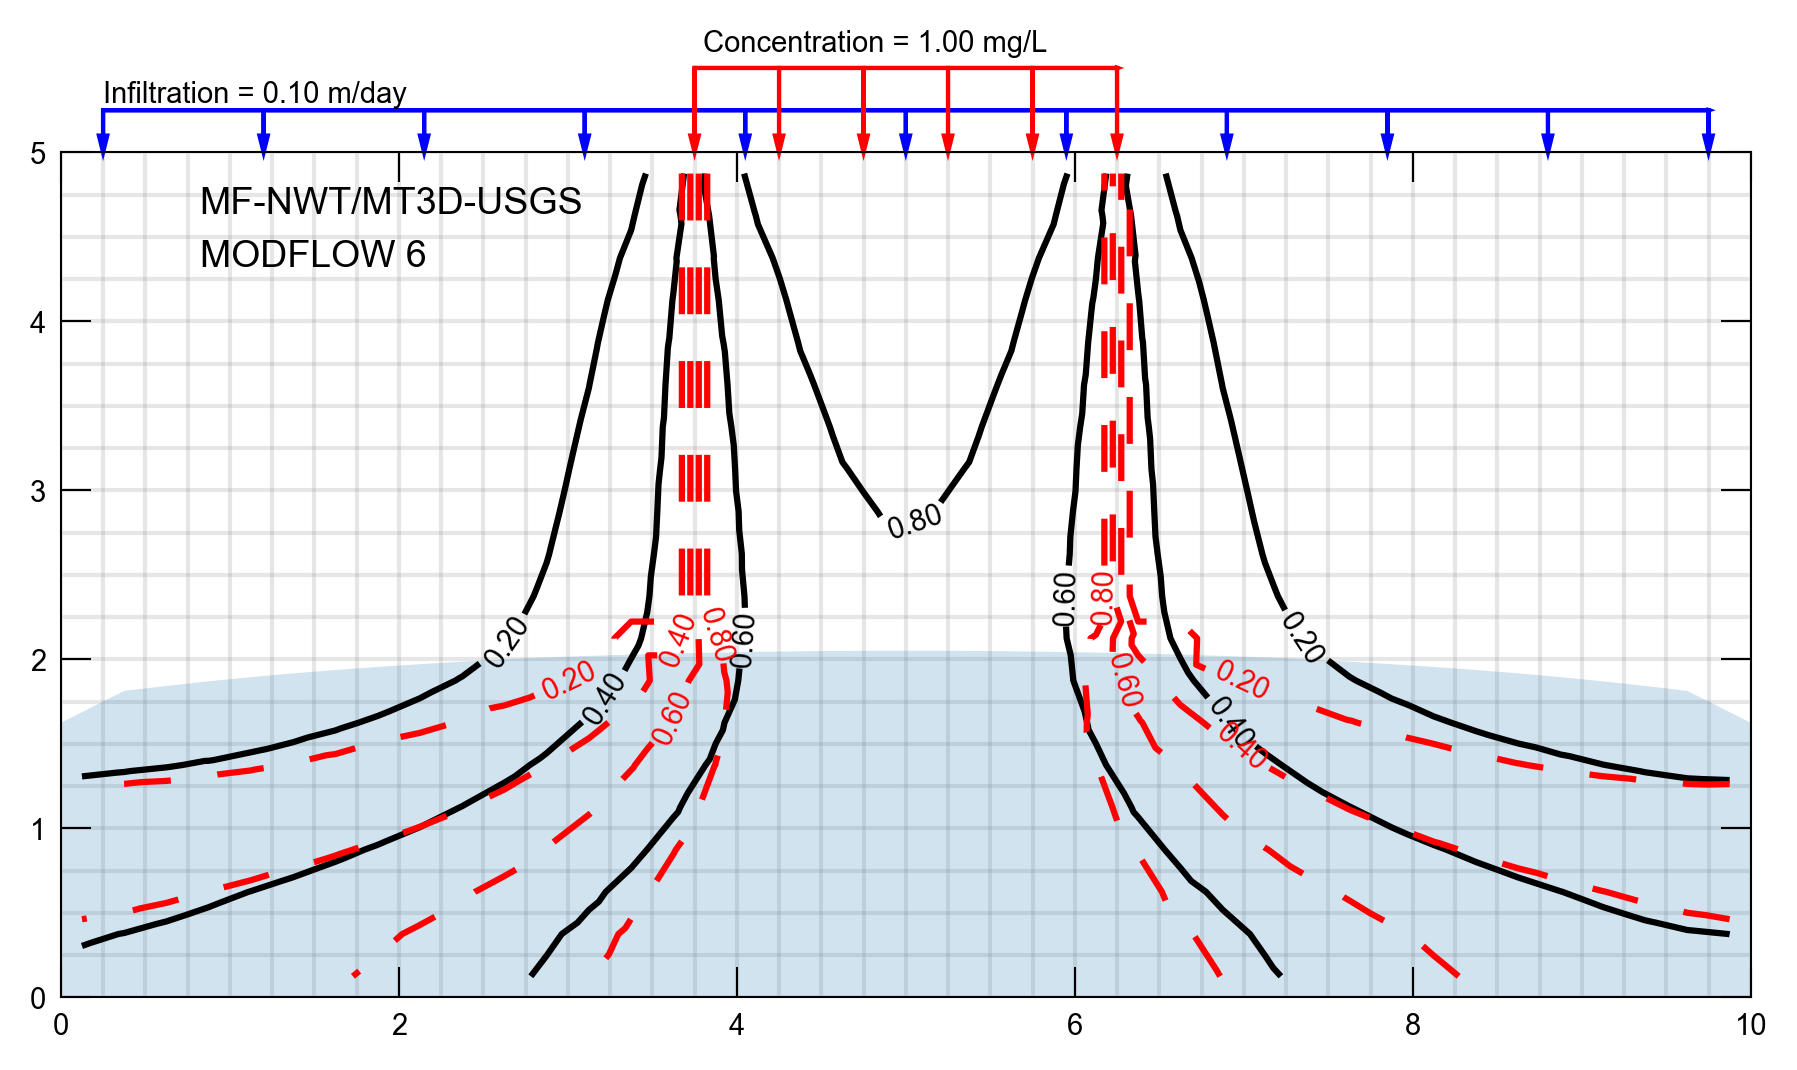

In [6]:
scenario(0, silent=True)

Building mf-nwt model...ex-gwt-uzt-2d-b
Building mt3d-usgs model...ex-gwt-uzt-2d-b
Building mf6gwt model...ex-gwt-uzt-2d-b


run_models took 11933.65 ms
Plotting model results...


/tmp/ipykernel_8637/333023305.py:102: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  lines = [cs1.collections[0], cs2.collections[0]]
/tmp/ipykernel_8637/333023305.py:102: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  lines = [cs1.collections[0], cs2.collections[0]]


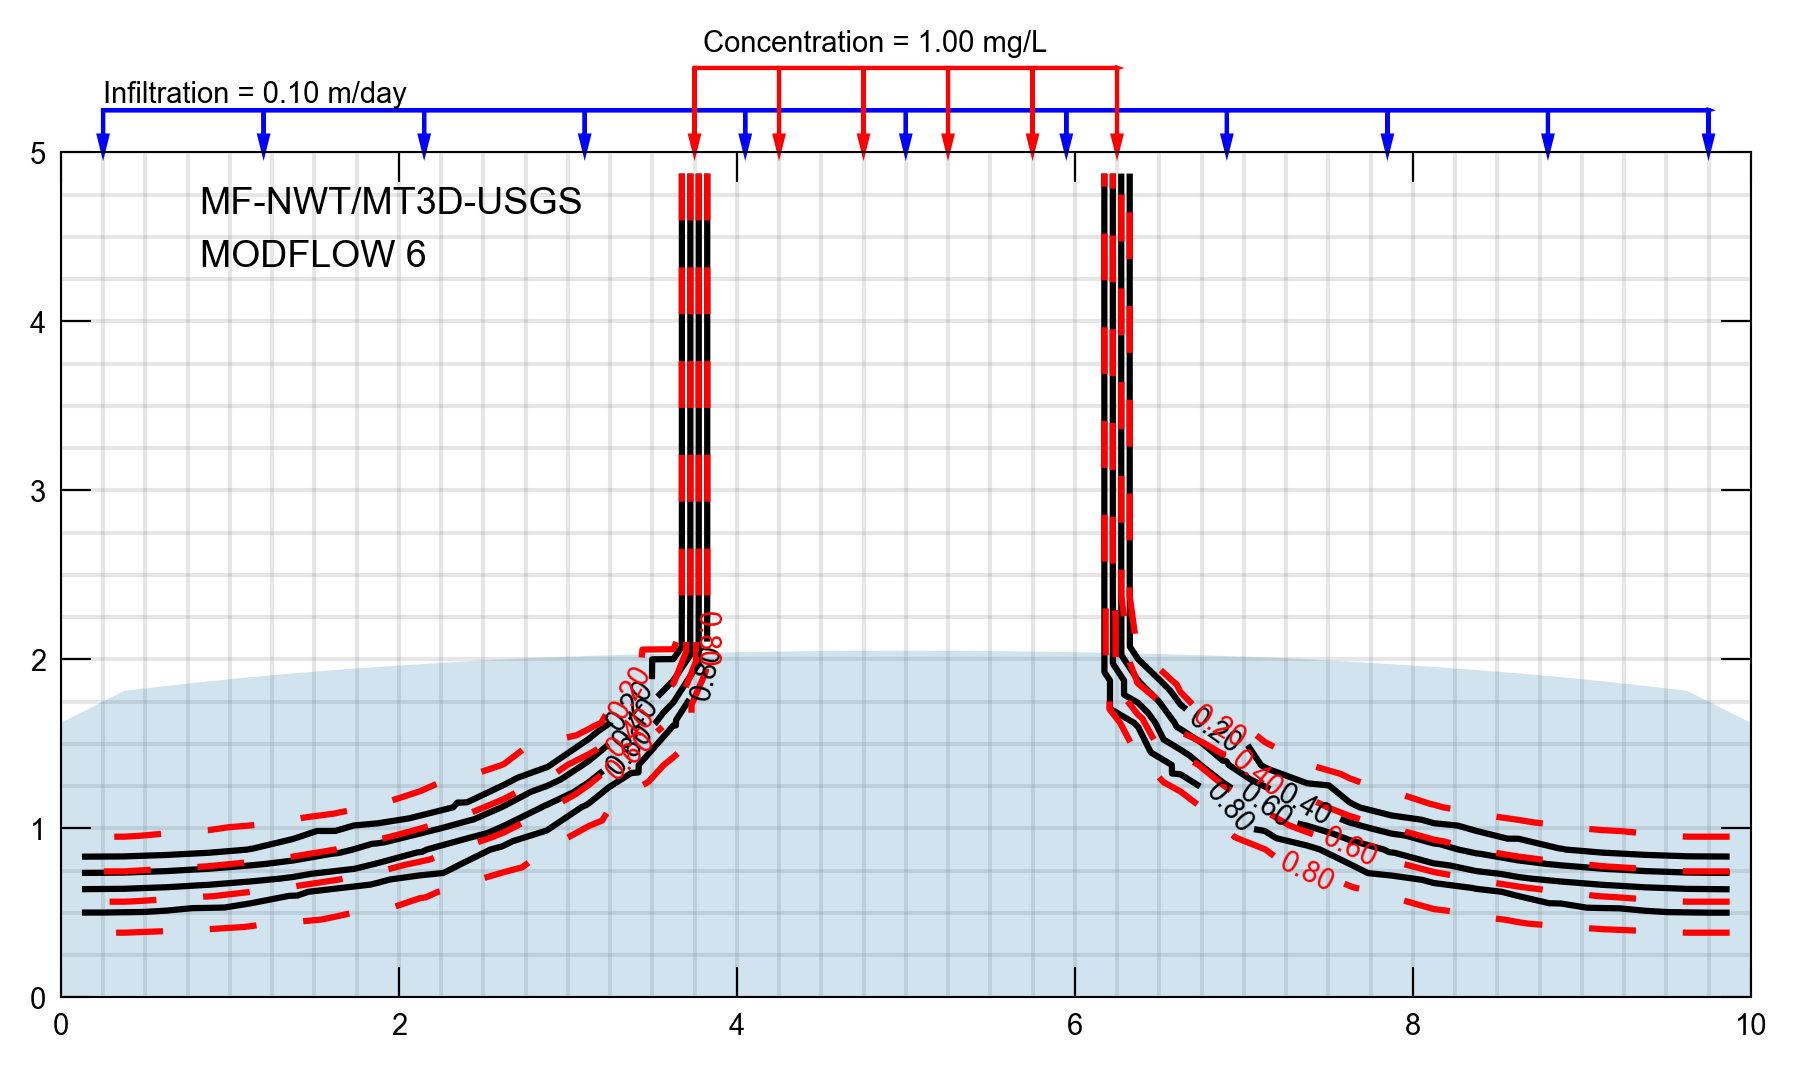

In [7]:
scenario(1, silent=True)